#### Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import os
from datetime import datetime

#### Data and model directories

In [5]:
data_dir = "../input/data/preprocessed/train"
test_data_dir = "../input/data/preprocessed/test/"
models_dir = '../model'

In [3]:
batch_size = 32
img_height = 500
img_width = 1024

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 356 files belonging to 2 classes.
Using 285 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 356 files belonging to 2 classes.
Using 71 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['fraud', 'not-fraud']


In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.77647066


#### Modelling

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 500, 1024, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 498, 1022, 16)       │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 249, 511, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 509, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 121, 252, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 60, 126, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 126, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 483840)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     123,863,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,887,394 (472.59 MB)

 Trainable params: 123,887,394 (472.59 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs=6
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/6
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.4477 - loss: 19.9000 - val_accuracy: 0.4366 - val_loss: 1.0177
Epoch 2/6
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 901ms/step - accuracy: 0.6219 - loss: 0.7476 - val_accuracy: 0.8732 - val_loss: 0.3895
Epoch 3/6
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 674ms/step - accuracy: 0.8488 - loss: 0.3249 - val_accuracy: 0.8732 - val_loss: 0.3414
Epoch 4/6
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 885ms/step - accuracy: 0.9105 - loss: 0.2146 - val_accuracy: 0.9437 - val_loss: 0.2289
Epoch 5/6
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 923ms/step - accuracy: 0.9494 - loss: 0.1350 - val_accuracy: 0.7606 - val_loss: 0.4060
Epoch 6/6
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 851ms/step - accuracy: 0.9009 - loss: 0.2164 - val_accuracy: 0.9718 - val_loss: 0.1286


#### Plot curves for training and validation

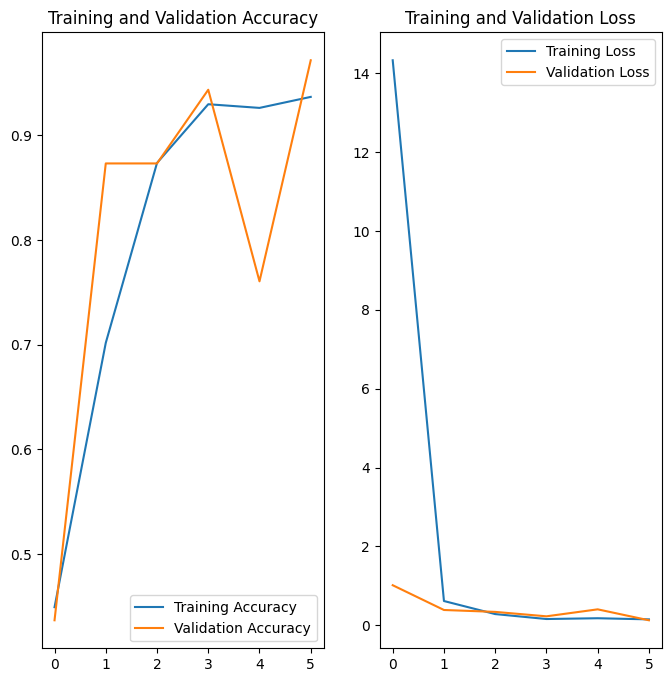

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Save model

In [15]:
model_name = 'proof_of_address_fraud_detection' + datetime.now().strftime("%d-%m-%Y-%H:%M:%S") + '.keras'
model.save(os.path.join(models_dir, model_name))

### Evaluate the model on test data

In [16]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width))

Found 44 files belonging to 2 classes.


In [17]:
loss, acc = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.9337 - loss: 0.1171
